In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.optim as optim

from UNMUNGE import *
from utils_unlearn import *
%matplotlib inline

%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np_seed, torch_seed = 20, 20

# Generating Artificial Data

In [3]:
fix_seed(np_seed, torch_seed)

no_of_data = 100
no_train_data = int(no_of_data*0.80)
no_test_data = int(no_of_data*0.20)
x = 0.6
y = 0.6

mu1 = torch.tensor([x, y])
sigma1 = 0.1*torch.eye(2)
normal1 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu1, covariance_matrix=sigma1)

mu2 = torch.tensor([x, -y])
sigma2 = 0.1*torch.eye(2)
normal2 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu2, covariance_matrix=sigma2)

mu3 = torch.tensor([-x, -y])
sigma3 = 0.1*torch.eye(2)
normal3 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu3, covariance_matrix=sigma3)

mu4 = torch.tensor([-x, y])
sigma4 = 0.1*torch.eye(2)
normal4 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu4, covariance_matrix=sigma3)

data1 = normal1.sample((no_of_data,))
label1 = torch.from_numpy(np.array([0]*no_of_data))
data2 = normal2.sample((no_of_data,))
label2 = torch.from_numpy(np.array([1]*no_of_data))
data3 = normal3.sample((no_of_data,))
label3 = torch.from_numpy(np.array([2]*no_of_data))
data4 = normal4.sample((no_of_data,))
label4 = torch.from_numpy(np.array([3]*no_of_data))


training_data = torch.concat((data1[:no_train_data],
                              data2[:no_train_data],
                              data3[:no_train_data],
                              data4[:no_train_data]
                              ))
training_labels = torch.concat((label1[:no_train_data],
                                label2[:no_train_data],
                                label3[:no_train_data],
                                label4[:no_train_data]
                                ))
train_ds = list(zip(training_data, training_labels))

test_data = torch.concat((data1[no_train_data:],
                          data2[no_train_data:],
                          data3[no_train_data:],
                          data4[no_train_data:]
                          ))
test_labels = torch.concat((label1[no_train_data:],
                            label2[no_train_data:],
                            label3[no_train_data:],
                            label4[no_train_data:]
                            ))
valid_ds = list(zip(test_data, test_labels))

# Plotting the Generated Data:

In [4]:
markers = ['o', 's', '^', 'd', 'p', 'x', 'X']
colors = ['blue', 'green', 'black', 'purple', 'red', 'brown', 'violet']
s = 500
ann_color = 'black'
ann_fontsize = 45
ann_fontweight = 'normal'#'bold'
ann_bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='black')
fontname='C059'#'serif'
xyticks_fontweight='normal'#'bold'#
xylabel_fontweight='normal'#'bold'#'normal'#
xyticks_fontsize = 45
title_fontsize = 30
xticks = np.linspace(-1.5, 1.5, 7)
yticks = np.linspace(-1.5, 1.5, 7)

annotate_xylist_train = [0, 80, 160, 240]
annotate_xylist_test = [0, 20, 40, 65]
mean_list = [mu1, mu2, mu3, mu4]

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 8)
# Set the font to C059
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['C059']
kwargs = {'fontsize' : ann_fontsize, 'fontweight' : ann_fontweight, 'bbox':ann_bbox, 'arrowprops':dict(facecolor='black', arrowstyle='->', linewidth=5)}

result_savepath = './results/Toy_Example_Results'
if not os.path.isdir(result_savepath):
    os.makedirs(result_savepath)


# Helper Functions:

In [5]:
def plot_graph(X, Y, xlabel = 'epoch', ylabel = 'avg. loss', plot_title = 'Loss', curve_label = 'loss: train', legend_loc = 'upper right',
               markersize = 20, marker = '', linewidth = 2, linestyle = '-', xyticks_fontsize = 20, title_fontsize = 25):
    
    plt.plot(X, Y,
            marker = marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            linestyle = linestyle, 
            label = curve_label
            )
    plt.xticks(fontsize = xyticks_fontsize)
    plt.yticks(fontsize = xyticks_fontsize)
    plt.xlabel(xlabel, fontsize = title_fontsize)
    plt.ylabel(ylabel, fontsize = title_fontsize)
    plt.grid(linestyle = '--')
    plt.legend(loc = legend_loc)
    plt.title(plot_title, fontsize = title_fontsize)
    
    plt.show(block = False)
    
    
def plot_data(data, no_of_data, annotate_xylist, title = 'Train Data', savepath = './',
              fontname='C059', fontweight='normal', fontsize=20, show=True):
    
    for i in range(4):
        X = data[i*no_of_data:(i+1)*no_of_data, 0]
        Y = data[i*no_of_data:(i+1)*no_of_data, 1]
        plt.scatter(X, Y,
                    marker = markers[i],
                    color = colors[i],
                    s = s
                    )
    plt.annotate('1', xy=data[annotate_xylist[0]], xytext=mean_list[0]+np.array([0.60, 0.60]), color = colors[0], **kwargs)
    plt.annotate('2',xy=data[annotate_xylist[1]],xytext=mean_list[1]+np.array([0.60, -0.60]),color = colors[1],**kwargs)
    plt.annotate('3',xy=data[annotate_xylist[2]],xytext=mean_list[2]+np.array([-0.75, -0.75]),color = colors[2],**kwargs)
    plt.annotate('4',xy=data[annotate_xylist[3]],xytext=mean_list[3]+np.array([-0.60, 0.60]),color = colors[3],**kwargs)
    plt.title(title, fontname=fontname, fontweight=fontweight, fontsize=fontsize+5)
    plt.xticks(xticks, fontname=fontname, fontweight=fontweight, fontsize=fontsize)
    plt.yticks(yticks, fontname=fontname, fontweight=fontweight, fontsize=fontsize)
    plt.xlim(-1.7, 1.7)
    plt.ylim(-1.7, 1.7)
    plt.grid()
    filename = title.replace(' ', '_')
    if savepath:
        plt.savefig(f'{savepath}/{filename}.png', bbox_inches='tight')
    if show:
        plt.show()
        
        
def plot_data_with_antisamples(data, antisamples, no_of_data, annotate_xylist, annotate_xylist_anti, title = 'Train Data with Unmunge', savepath = './',
              fontname='C059', fontweight='normal', fontsize=20):
    
    plot_data(data, no_of_data, annotate_xylist, title = title, savepath = '',
              fontname=fontname, fontweight=fontweight, fontsize=fontsize, show=False)
    plt.scatter(antisamples[:, 0], antisamples[:, 1], marker = 'p', color = 'red', s = s)
    for point in annotate_xylist_anti:
        plt.annotate(f'n', xy=point, xytext=point+0.5, color = 'red', **kwargs)
    filename = title.replace(' ', '_')
    if savepath:
        plt.savefig(f'{savepath}/{filename}.png', bbox_inches='tight')
    plt.show()


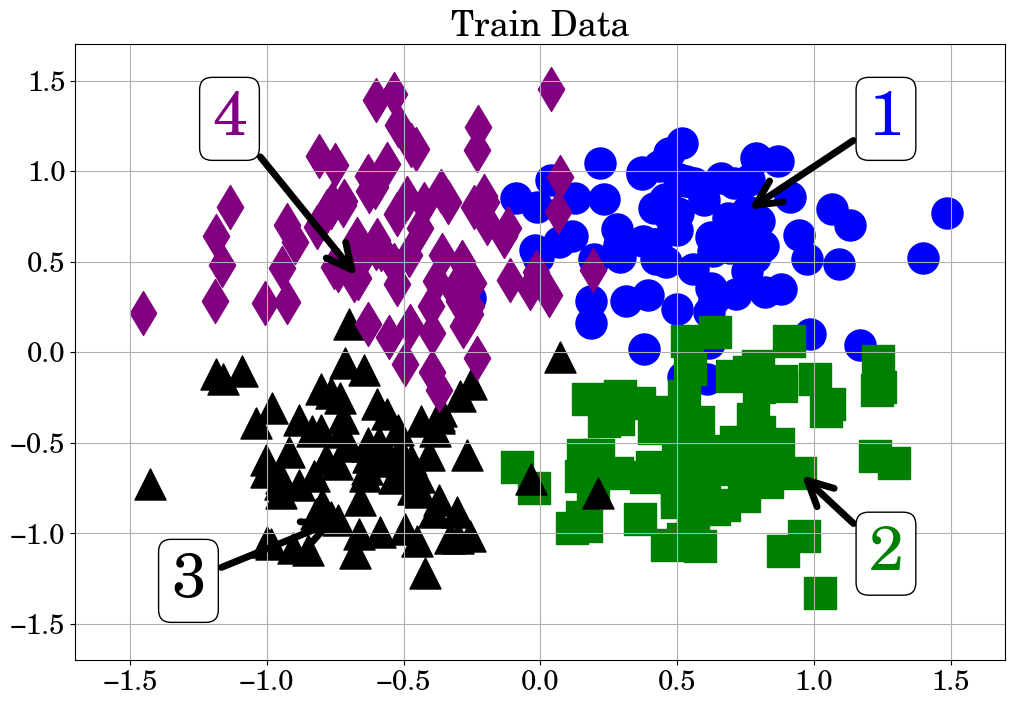

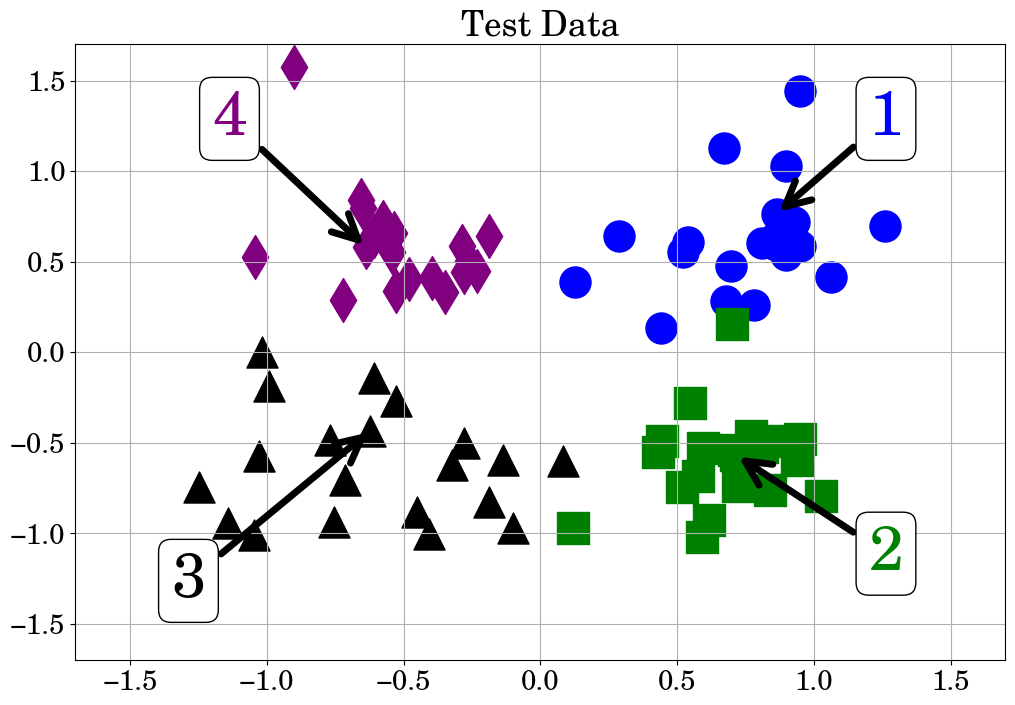

In [6]:
plot_data(data=training_data, no_of_data=no_train_data, annotate_xylist=annotate_xylist_train, title='Train Data', savepath=result_savepath)
plot_data(data=test_data, no_of_data=no_test_data, annotate_xylist=annotate_xylist_test, title='Test Data', savepath=result_savepath)

# Defining the Model

In [7]:
fix_seed(np_seed, torch_seed)

## Classification Model
model = nn.Sequential(nn.Linear(2, 5),
                      nn.Sigmoid(),
                      nn.Linear(5, 4),
                      nn.Softmax(dim = 1)
                      )

optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)
print(f'Model: {summary(model, (128, 2))}\n')


Model: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 4]                  --
├─Linear: 1-1                            [128, 5]                  15
├─Sigmoid: 1-2                           [128, 5]                  --
├─Linear: 1-3                            [128, 4]                  24
├─Softmax: 1-4                           [128, 4]                  --
Total params: 39
Trainable params: 39
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01



# Training the Model:

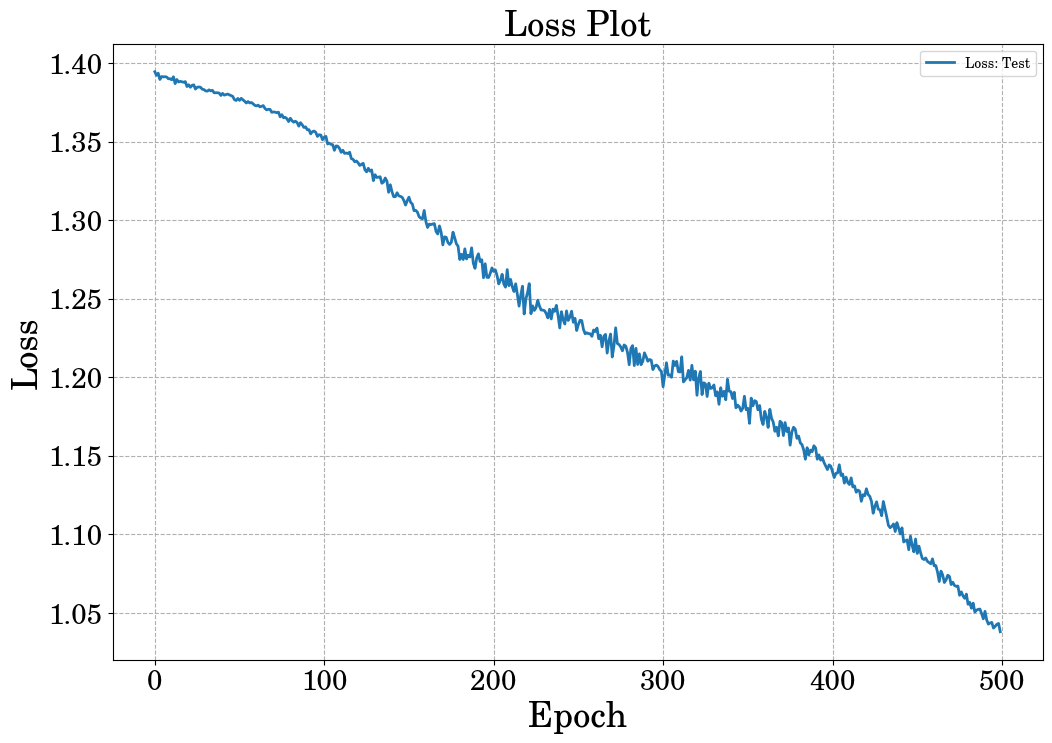

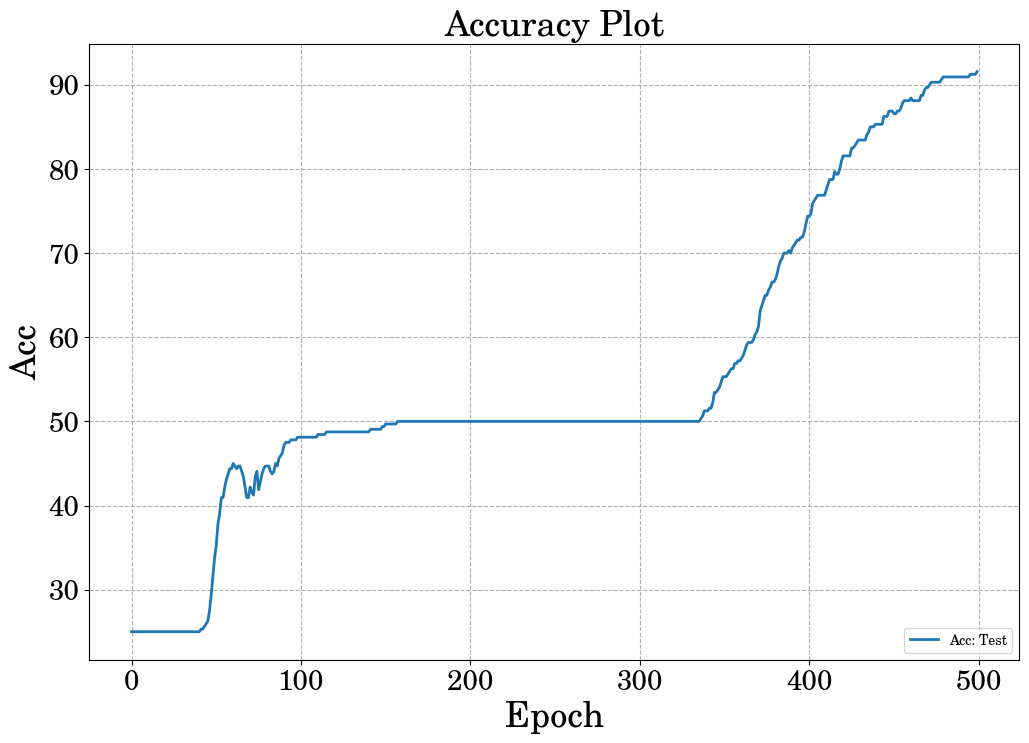

Accuracy on the Training Data after Training: 91.56


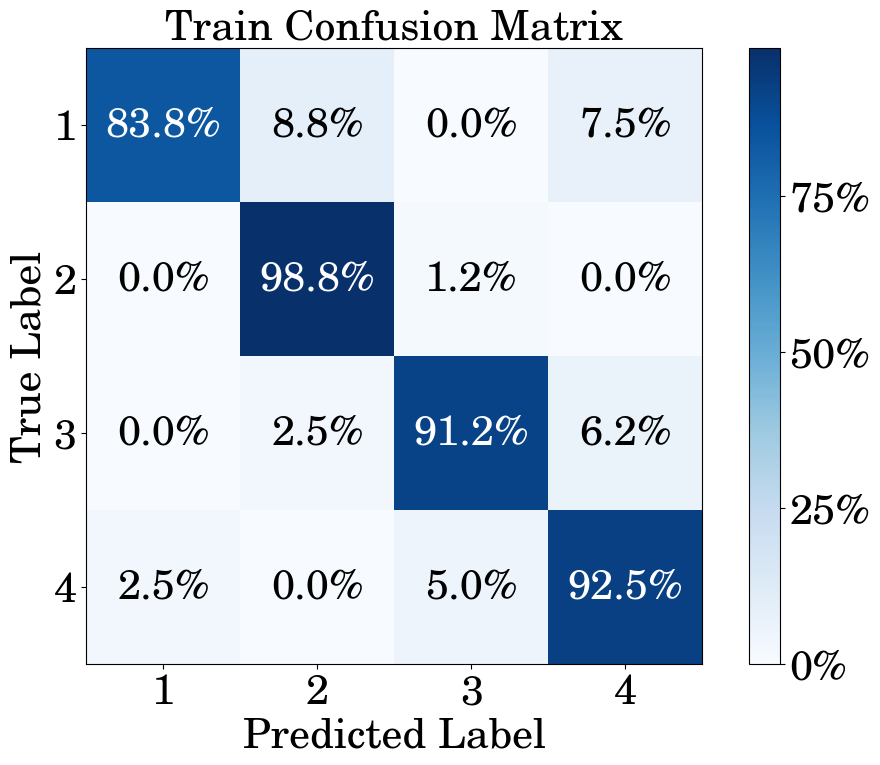

Accuracy on the Test Data after Training: 95.0


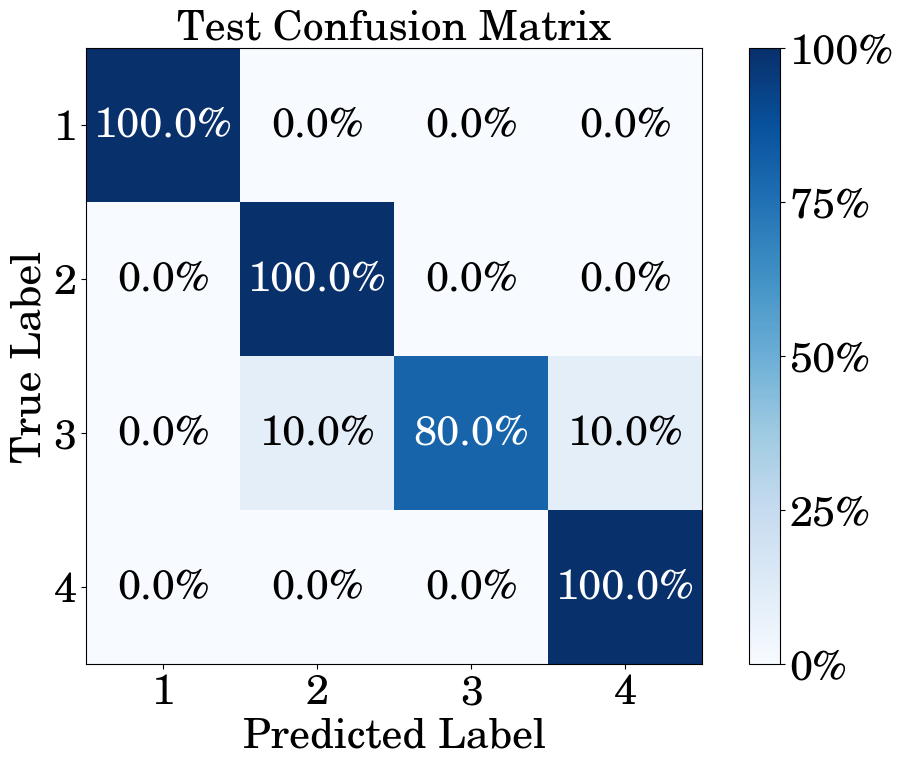

In [8]:
fix_seed(np_seed, torch_seed)

batch_size = 128
no_of_train_epochs = 500

train_loader = DataLoader(list(zip(training_data,training_labels)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size=batch_size, shuffle=False)

model, epoch_train_losses, epoch_train_accs = train(model=model, optimizer= optimizer,
                                                    train_loader=train_loader, no_of_epochs=no_of_train_epochs) 


## Plotting Loss
plot_graph(X = np.arange(len(epoch_train_losses)), Y = epoch_train_losses, xlabel='Epoch',
           ylabel='Loss', curve_label='Loss: Test', plot_title='Loss Plot')

## Plotting Accuracies
plot_graph(X = np.arange(len(epoch_train_accs)), Y = epoch_train_accs, xlabel='Epoch',
           ylabel='Acc', curve_label='Acc: Test', plot_title='Accuracy Plot', legend_loc='lower right')

# On Train Data
confusion_matrix, acc, _ = accuracy_(model=model, dataloader=train_loader)
print(f'Accuracy on the Training Data after Training: {acc}')
plot_confusion_matrix(confusion_matrix=confusion_matrix, title='Train Confusion Matrix')

# On Test Data
confusion_matrix, acc, _ = accuracy_(model=model, dataloader=test_loader)
print(f'Accuracy on the Test Data after Training: {acc}')
plot_confusion_matrix(confusion_matrix=confusion_matrix, title='Test Confusion Matrix')

# Unlearn Parameters

In [9]:
unlearn_cls = 0

# Unlearn Using UNSIR Method(Chundawat et al., 2023)

#### Step-1: Noise Generation

In [10]:
fix_seed(np_seed, torch_seed)
train_epochs = 50
num_steps = 8
num_noises = 256
fully_trained_model_em = copy.deepcopy(model)

# defining the noise structure
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)
        
    def forward(self):
        return self.noise
    

generated_noises = {}
for cls in range(4):
    noises = Noise(num_noises, 2)
    init_noise = copy.deepcopy(noises())
    opt = torch.optim.Adam(noises.parameters(), lr = 0.1)

    unlearn_labels = torch.from_numpy(np.array([cls]*num_noises)).to(device)
    for epoch in range(train_epochs):
        total_loss = []
        for batch in range(num_steps):
            inputs = noises().to(device)
            outputs = fully_trained_model_em(inputs)
            loss = -F.cross_entropy(outputs, unlearn_labels)+ 0.1*torch.mean(torch.sum(torch.square(inputs), [1]))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss.append(loss.cpu().detach().numpy())
        # print("Loss: {}".format(np.mean(total_loss)))
    generated_noises[cls] = noises().detach().numpy()

#### Step-2: Plotting Generated Noises

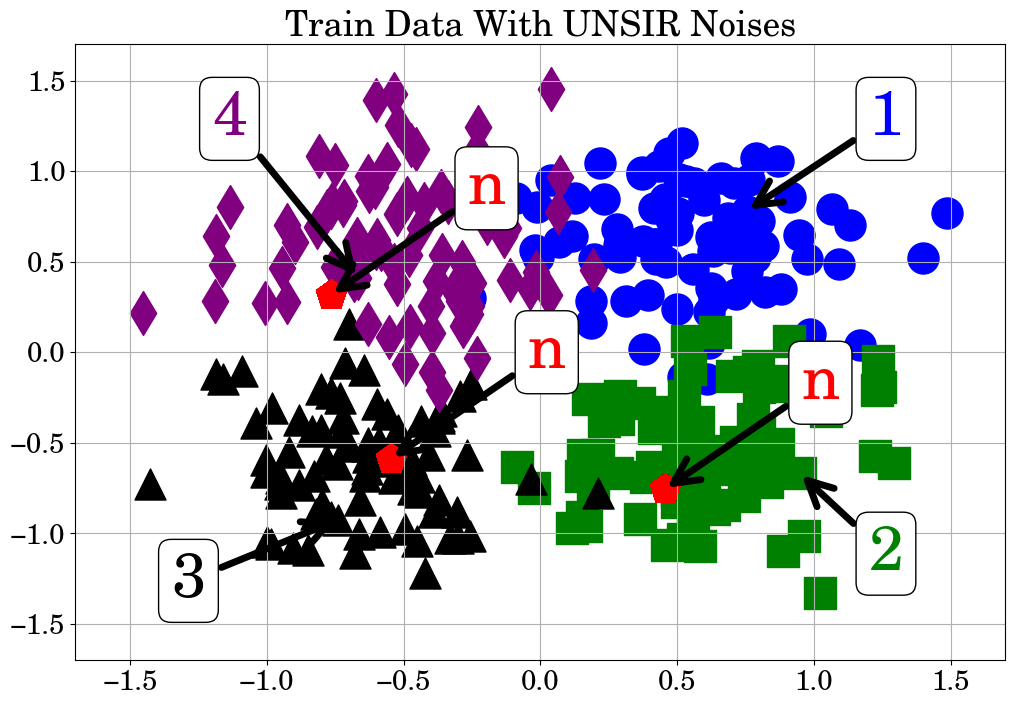

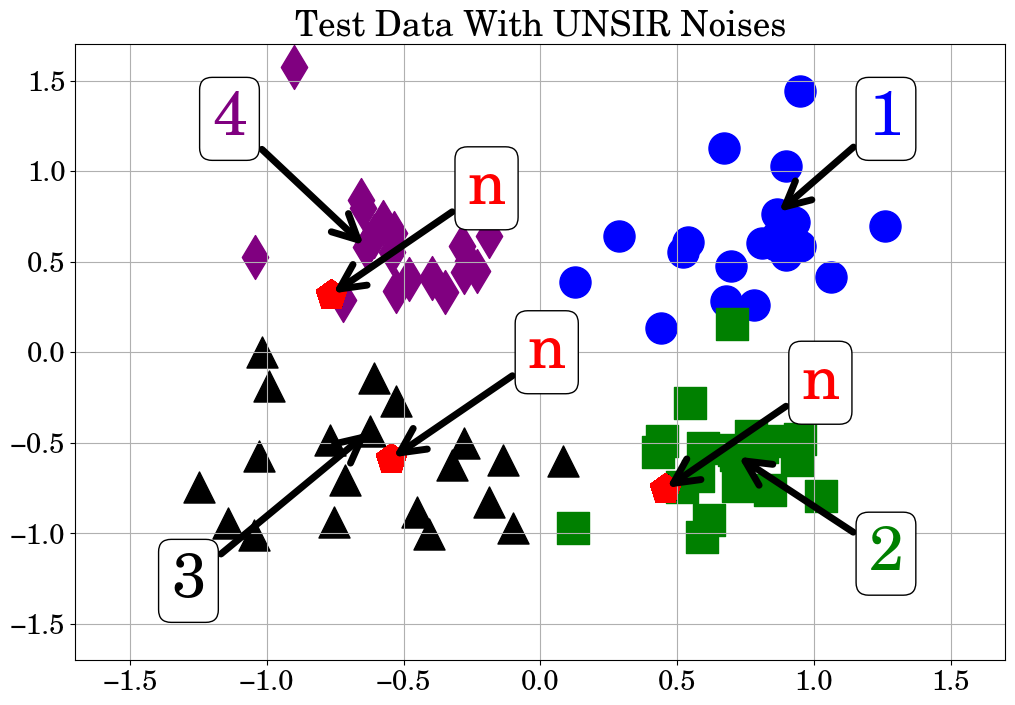

In [11]:
antisamples = generated_noises[unlearn_cls]
antisamples_ann_list = [antisamples[0], antisamples[1], antisamples[11]]
plot_data_with_antisamples(data=training_data, antisamples=antisamples, no_of_data=no_train_data, annotate_xylist=annotate_xylist_train,
                           annotate_xylist_anti=antisamples_ann_list, title='Train Data With UNSIR Noises', savepath=result_savepath)

plot_data_with_antisamples(data=test_data, antisamples=antisamples, no_of_data=no_test_data, annotate_xylist=annotate_xylist_test,
                           annotate_xylist_anti=antisamples_ann_list, title='Test Data With UNSIR Noises', savepath=result_savepath)



#### Unlearn Helper:

In [12]:
# Error Max Unleanring
unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True) 


impair_data = torch.concat(list(torch.from_numpy(generated_noises[unlearn_cls]))+list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
impair_label = [torch.tensor(unlearn_cls)]*len(generated_noises[unlearn_cls])+list(y for _, y in train_loader.dataset if y != unlearn_cls)
impair_loader = DataLoader(list(zip(impair_data, impair_label)), batch_size=batch_size, shuffle=True)

repair_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
repair_label = list( y for _, y in train_loader.dataset if y != unlearn_cls)
repair_loader = DataLoader(list(zip(repair_data, repair_label)), batch_size=batch_size, shuffle=True)

#### Actual Unlearning(Repair + Impair):

Results after 1 + 1 epoch of Impair & Repair Step:

Accuracy after unlearning(epoch - 1) on Unlearn Data: 100.0
Accuracy after unlearning(epoch - 1) on Retain Data: 10.0
Corresponding confusion matrix: 


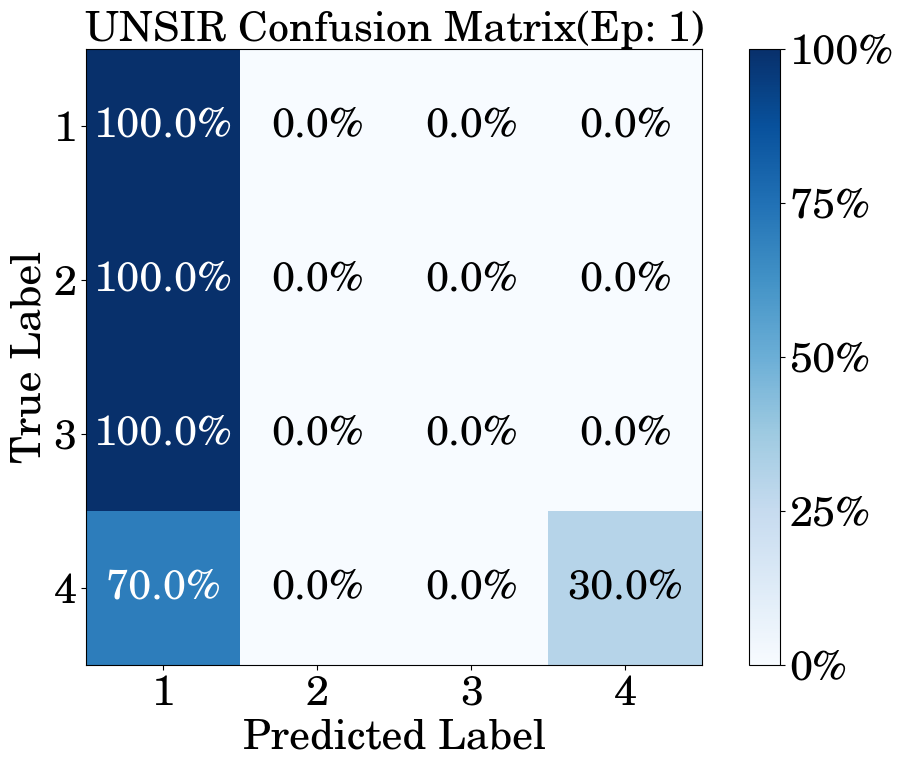

Accuracy after unlearning(epoch - 2) on Unlearn Data: 5.0
Accuracy after unlearning(epoch - 2) on Retain Data: 66.67
Corresponding confusion matrix: 


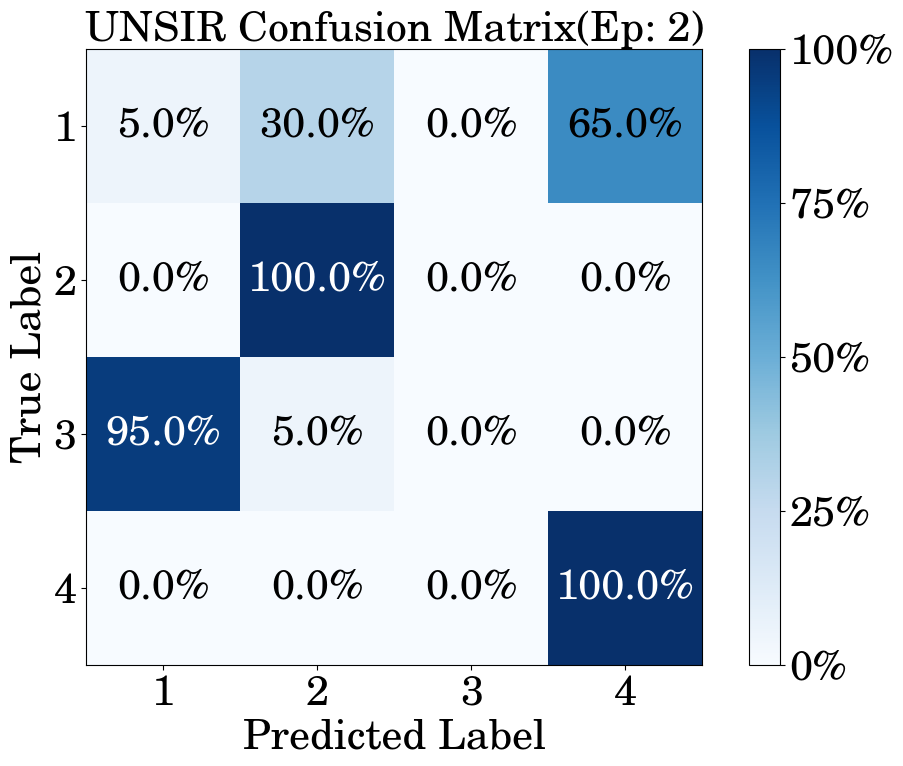

Accuracy after unlearning(epoch - 3) on Unlearn Data: 0.0
Accuracy after unlearning(epoch - 3) on Retain Data: 66.67
Corresponding confusion matrix: 


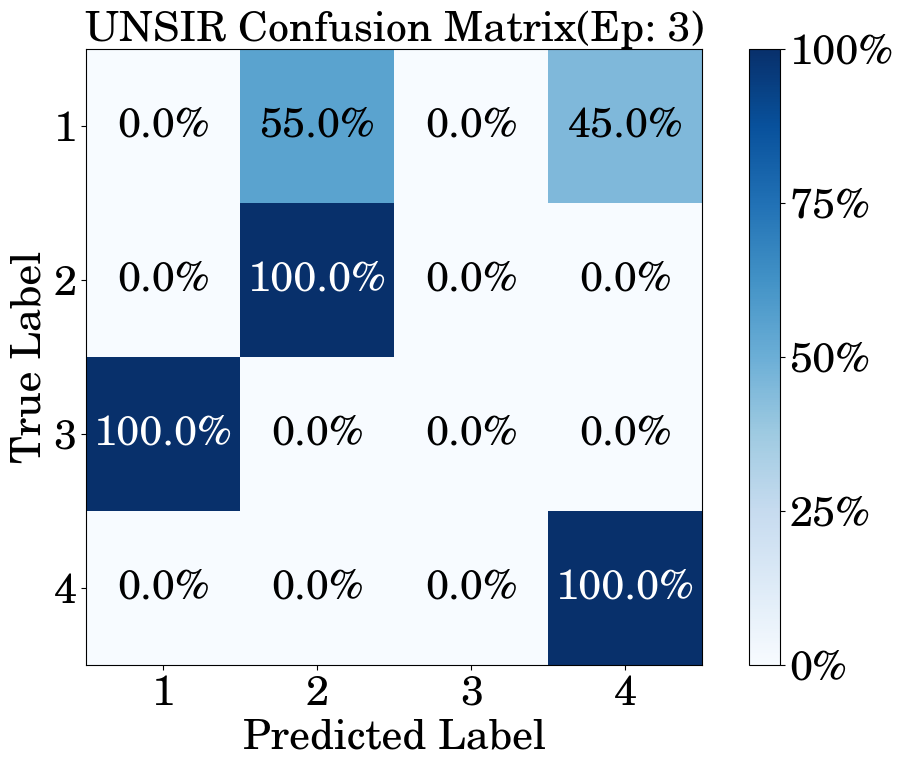

In [13]:
fix_seed(np_seed, torch_seed)

no_of_impair_repair_pairs = 3
print('Results after 1 + 1 epoch of Impair & Repair Step:\n')
err_max_unlearn_model = copy.deepcopy(fully_trained_model_em)
for epoch in range(no_of_impair_repair_pairs):
    optimizer = optim.Adam(params=err_max_unlearn_model.parameters(), lr = 300*1e-3)
    err_max_unlearn_model, _, _ = train(model=err_max_unlearn_model, optimizer=optimizer, train_loader=impair_loader, no_of_epochs=1)

    optimizer = optim.Adam(params=err_max_unlearn_model.parameters(), lr = 150*1e-3)
    err_max_unlearn_model, err_max_loss, err_max_acc = train(model=err_max_unlearn_model, optimizer=optimizer, train_loader=repair_loader, no_of_epochs=1)

    confusion_matrix, acc, classwise_accuracy, retain_acc, unlearn_acc = accuracy(model=err_max_unlearn_model, dataloader=test_loader, unlearn_cls = unlearn_cls)
    print(f'Accuracy after unlearning(epoch - {epoch+1}) on Unlearn Data: {unlearn_acc}')
    print(f'Accuracy after unlearning(epoch - {epoch+1}) on Retain Data: {retain_acc}')
    print(f'Corresponding confusion matrix: ')
    
    plot_confusion_matrix(confusion_matrix=confusion_matrix, title=f'UNSIR Confusion Matrix(Ep: {epoch+1})', result_savepath=result_savepath)

# Unlearning using Proposed Method(Unmunge algorithm):

#### Step-1: Noise Generation

In [14]:
all_data = [data1, data2, data3, data4]
all_labels = [label1, label2, label3, label4]


unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True) 


retain_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
retain_labels = list( y for _, y in train_loader.dataset if y != unlearn_cls)
retain_loader = DataLoader(list(zip(retain_data, retain_labels)), batch_size=batch_size, shuffle=True)

unmunge_data, _, _, _ = UNMUNGE_(unlearn_data,
                    retain_data=retain_data.numpy(),
                    retain_labels=np.array(retain_labels),
                    local_variance=3,
                    size_multiplier=5,
                    p=0.50,
                    tail_randomized=150,
                    no_generated_data=80,
                    eps=0.1,
                    convex_combination=True
                    )


Number of unlearn data = 80
Number of retain data = 240


100%|██████████| 5/5 [00:00<00:00, 1240.40it/s]

Number of Generated Data = 80
Time needed to calculate Pairwise Distance = 0.05344271659851074 sec
Time needed for Sorting = 0.0016963481903076172 sec
Time needed to generate the samples = 0.08071732521057129 sec


#### Step-2: Plotting Generated Noises

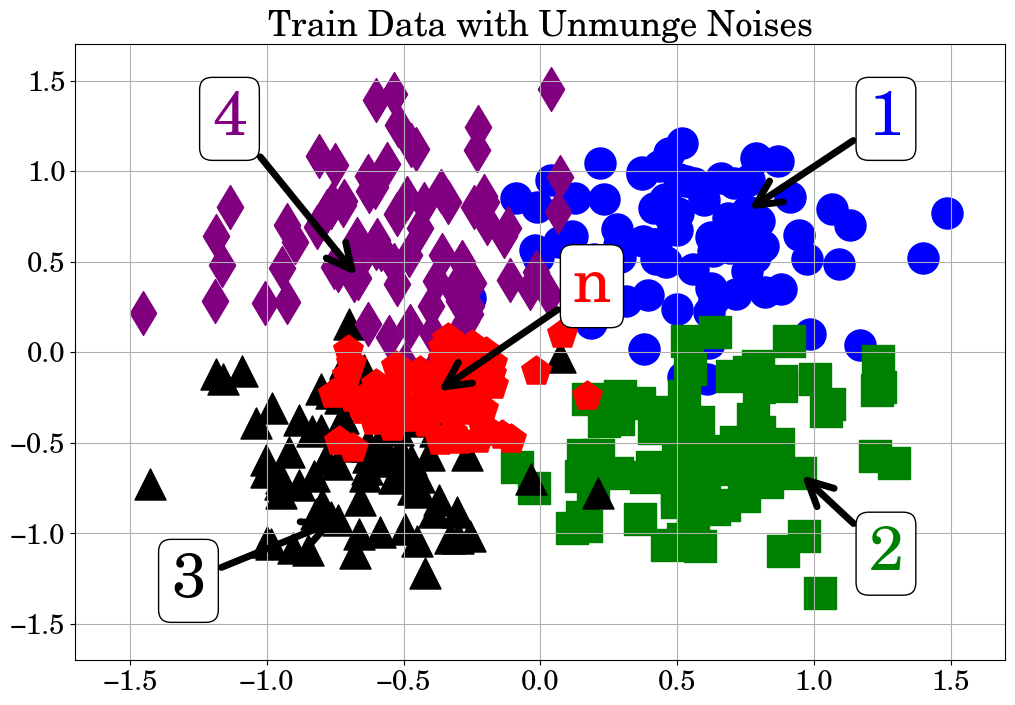

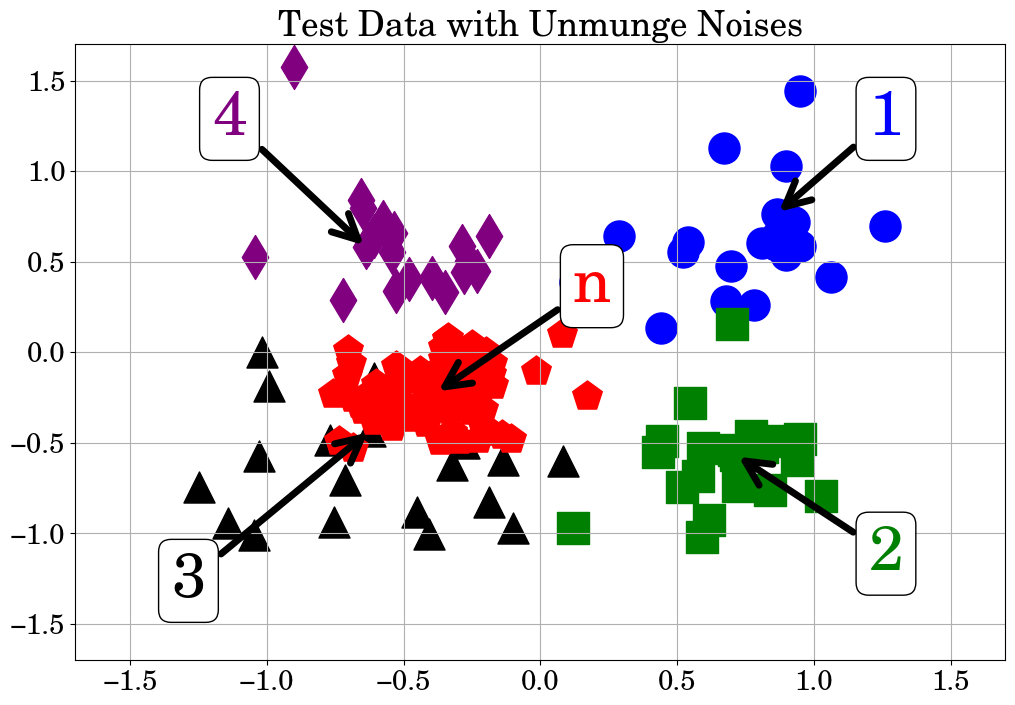

In [15]:
plot_data_with_antisamples(data=training_data, antisamples=unmunge_data, no_of_data=no_train_data, annotate_xylist=annotate_xylist_train,
                           annotate_xylist_anti=[unmunge_data.mean(dim=0)], title='Train Data with Unmunge Noises', savepath=result_savepath)

plot_data_with_antisamples(data=test_data, antisamples=unmunge_data, no_of_data=no_test_data, annotate_xylist=annotate_xylist_test,
                           annotate_xylist_anti=[unmunge_data.mean(dim=0)], title='Test Data with Unmunge Noises', savepath=result_savepath)

#### Unlearn Healper:

In [16]:
unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True)

repair_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
repair_label = list( y for _, y in train_loader.dataset if y != unlearn_cls)
repair_loader = DataLoader(list(zip(repair_data, repair_label)), batch_size=batch_size, shuffle=True) 

unmunge_train_data = torch.concat((repair_data, unmunge_data)).type(torch.float)
unmunge_train_labels = torch.concat((torch.tensor(repair_label), torch.tensor([unlearn_cls]*len(unmunge_data))))
unmunge_train_loader = DataLoader(list(zip(unmunge_train_data, unmunge_train_labels)), batch_size=batch_size, shuffle=True)

#### Actual Unlearning(Unmunge):

Accuracy after unlearning on Unlearn Data: 0.0
Accuracy after unlearning on Retain Data: 95.0
Corresponding confusion matrix: 


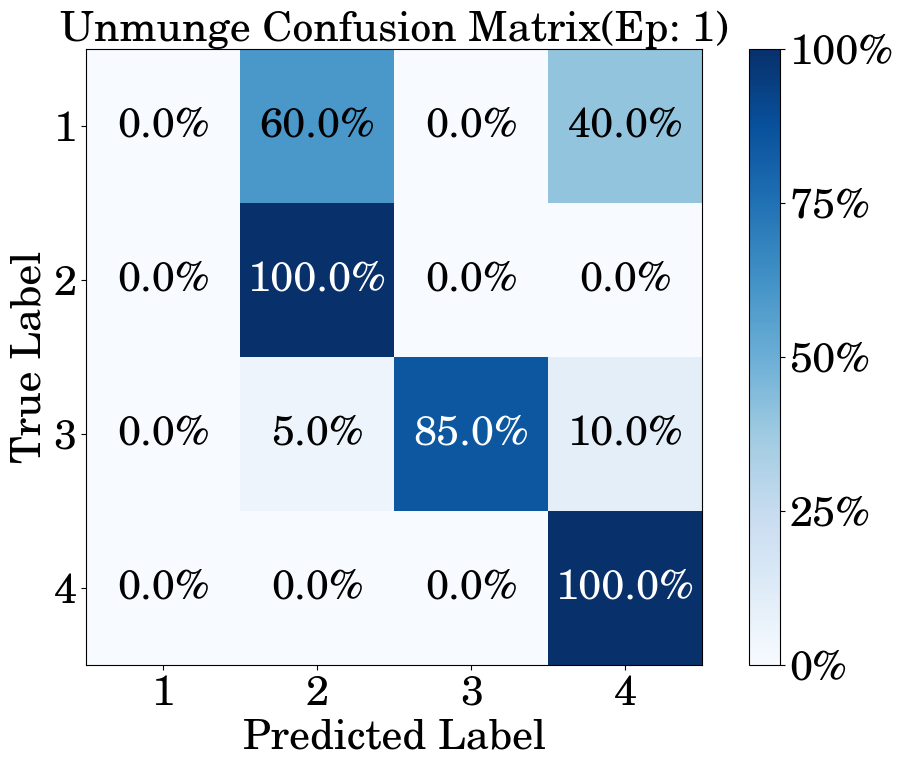

In [18]:
fix_seed(np_seed, torch_seed)
no_of_epochs_unmg = 1
fully_trained_model_umng = copy.deepcopy(model)

for i in range(no_of_epochs_unmg):
    ## Unlearning
    optimizer = optim.Adam(params=fully_trained_model_umng.parameters(), lr = 300*1e-3)
    umng_unlearn_model, umng_loss, umng_acc = train(model=fully_trained_model_umng, optimizer=optimizer, train_loader=unmunge_train_loader, no_of_epochs = 1)

    confusion_matrix, acc, classwise_accuracy, retain_acc, unlearn_acc = accuracy(model=umng_unlearn_model, dataloader=test_loader, unlearn_cls = unlearn_cls)
    print(f'Accuracy after unlearning on Unlearn Data: {unlearn_acc}')
    print(f'Accuracy after unlearning on Retain Data: {retain_acc}')
    print(f'Corresponding confusion matrix: ')
    
    plot_confusion_matrix(confusion_matrix=confusion_matrix, title=f'Unmunge Confusion Matrix(Ep: {no_of_epochs_unmg})', result_savepath=result_savepath)